In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MID_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [6]:
from collections import defaultdict as ddict
def fil_name2paras(fil_name):
    """plz be careful about 0.1 and 1
    """
    tmp = fil_name.split("_")
    paras = {}
    for itm in tmp:
        if '--' in itm:
            k, v = itm.split("--")
            v = f"0.{v}"
        elif '-' in itm:
            k, v = itm.split("-")
            # to be compatible with old simu
            if v.startswith("0"):
                v = f"0.{v}"
        else:
            continue
        
        if k.startswith("T"):
            k = "n_T"
        elif k.startswith("decay"):
            k = "weight_decay"
        elif k.startswith("infeat"):
            k = "n_infeat"
        paras[k] = float(v)
    paras["rep"] = int(tmp[1])
    return paras


In [7]:
setting = "setting1"
d = 10 # vary d 10, 300
cs = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.8, 1.2]
Ks = [10, 20, 40, 80, 160, 320]

[10, 20, 40, 80, 160, 320]

In [8]:
# get results of DDIM and naive
def _add_res(res, key, dict_res):
    if key not in res.keys():
        key = "L" + key
        if key not in res.keys():
            return None
    dict_res["Len"].append(res[key][-1])
    dict_res["ITE"].append(res[key][0])
    if key.startswith("DDIM"):
        dict_res["method"].append("L"+key)
    else:
        dict_res["method"].append(key)
    for ky, v in cur_paras.items():
        dict_res[ky].append(v)
    dict_res["c"].append(c)
    dict_res["K"].append(K)
        
our_res = ddict(list)
for c in cs:
    for K in Ks:
        res_dir = RES_ROOT/f"simuLCPHOMOK_{setting}_d{d}_n10000_c{c*100:.0f}_K{K}"
        all_fils = list(res_dir.glob("*n_T-*.pkl"));
        for fil in all_fils:
            cur_paras = fil_name2paras(fil.stem);
            res = load_pkl(fil, verbose=False);
            
            _add_res(res, key="DDIM", dict_res=our_res)
            _add_res(res, key="DDIM_val", dict_res=our_res)
            
            for model_ix in range(500, 6000, 500):
                _add_res(res, key=f"DDIM_ep{model_ix}", dict_res=our_res)
                _add_res(res, key=f"DDIM_ep{model_ix}_val", dict_res=our_res)
        
our_res_df = pd.DataFrame(our_res);

# Select com for each rep

In [9]:
# get opt obs based on val set
def _get_opt_obs_given_repix(rep_ix, c, K,
                             all_res_df, 
                             method_key="DDPM", cutoff=None):
    cols = ["method", "lr", "n_infeat", "n_T", 
            "weight_decay", "upblk", "downblk", "rep", "c", "K"]
    kpidx = np.bitwise_and(all_res_df["rep"] == rep_ix, 
                           all_res_df["method"].map(lambda x: ("val" in x) and (method_key in x)));
    kpidx = np.bitwise_and(kpidx, all_res_df["c"] == c)
    kpidx = np.bitwise_and(kpidx, all_res_df["K"] == K)
    if cutoff is not None:
        kpidx1 = np.bitwise_and(kpidx, all_res_df["ITE"]>cutoff)
    if kpidx1.sum() > 0:
        kpidx = kpidx1
        best_val = all_res_df[kpidx].sort_values(by="Len").iloc[0]
    else:
        # if not ITE > target, use the one with largest ITE
        best_val = all_res_df[kpidx].sort_values(by="ITE").iloc[-1]
        
    mask = np.ones(all_res_df.shape[0], dtype=bool)
    for col in cols:
        if col.startswith("method"):
            #v = best_val[col]
            v = best_val[col].split("_val")[0]
            mask = np.bitwise_and(mask, all_res_df[col].isin([v]))
            
        else: 
            v = best_val[col]
            mask = np.bitwise_and(mask, all_res_df[col] == v)
    return all_res_df[mask]

In [10]:
#our_res_df1 = our_res_df
best_res = []
cutoff = 0.95
for cur_rep in range(50):
    for c in cs:
        for K in Ks:
            best_res.append(_get_opt_obs_given_repix(cur_rep, 
                                                     c, 
                                                     K,
                                                     our_res_df, 
                                                     "LDDIM", cutoff))
    
best_res = pd.concat(best_res);
best_res1 = best_res.copy();

In [11]:
# put the results together
save_pkl(MID_ROOT/f"tmpdf_{setting}_d{d}_abl.pkl", best_res1);

Save to /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../mid_results/tmpdf_setting1_d10_abl.pkl


# Plot

In [12]:
d = 10

10

In [13]:
best_res = load_pkl(MID_ROOT/f"tmpdf_{setting}_d{d}_abl.pkl");
best_res1 = best_res.copy()
best_res["method"] = best_res1["method"].map(lambda x: x.split("_")[0])
best_res = best_res[["Len", "ITE", "method", "rep", "c", "K"]];
best_res["c1"] = best_res["c"].map(lambda x: x if x > 0 else np.inf)

Load file /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../mid_results/tmpdf_setting1_d10_abl.pkl


In [14]:
ITEmat = best_res.groupby(["c1", "K"])["ITE"].mean().unstack()
Lenmat = best_res.groupby(["c1", "K"])["Len"].mean().unstack();

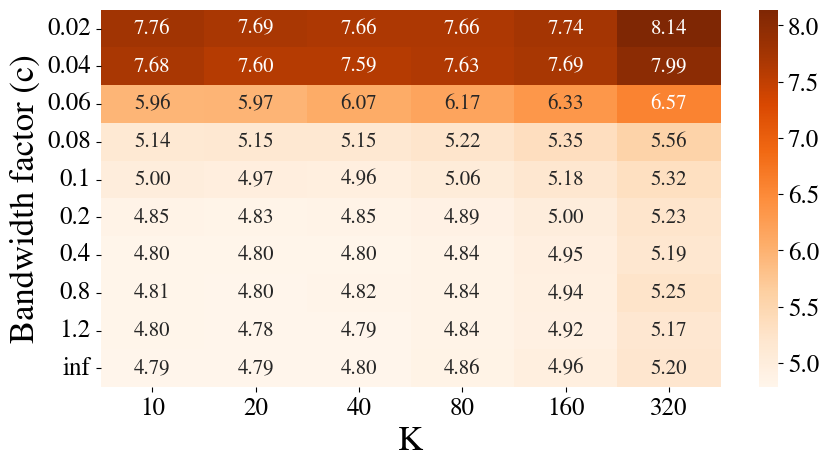

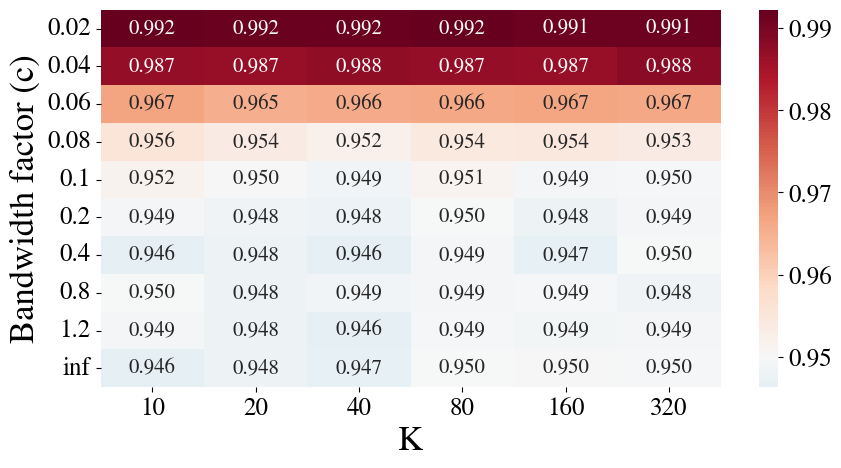

In [15]:
plt.figure(figsize=[10, 5])
sns.heatmap(Lenmat, annot=Lenmat, fmt=".2f", cmap="Oranges")
plt.ylabel("Bandwidth factor (c)")
plt.savefig(FIG_ROOT/f"abl_{setting}_d{d}_Len.jpg")

plt.figure(figsize=[10, 5])
sns.heatmap(ITEmat, annot=True, fmt=".3f", cmap="RdBu_r", center=0.95)
plt.ylabel("Bandwidth factor (c)")
plt.savefig(FIG_ROOT/f"abl_{setting}_d{d}_prob.jpg")